# CSE 1015 - J - Component
# Fire detection

Team Members 

19BAI1035 - S.O.Narendran\
19BAI1160 - Barath Hari Hara Moorthy

## Importing the necessary libraries

In [1]:
import tensorflow as tf 
import os
import shutil
import glob
import random
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [2]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.4.1


## Preprocessing of Data

In [3]:
os.chdir("data/initial")

In [4]:
if (os.path.isdir("data/initial/fire") is False):
    try:
        os.makedirs('train/fire')
        os.makedirs('train/notFire')
        os.makedirs('valid/fire')
        os.makedirs('valid/notFire')
        os.makedirs('test/fire')
        os.makedirs('test/notFire')
    except:
        pass
    try:
        for c in random.sample(glob.glob('fire*'), 519):
            shutil.move(c, 'train/fire')
        for c in random.sample(glob.glob('notFire*'), 400):
            shutil.move(c, 'train/notFire')
        for c in random.sample(glob.glob('fire*'), 173):
            shutil.move(c, 'valid/fire')
        for c in random.sample(glob.glob('notFire*'), 150):
            shutil.move(c, 'valid/notFire')
        for c in random.sample(glob.glob('fire*'), 173):
            shutil.move(c, 'test/fire')
        for c in random.sample(glob.glob('notFire*'), 150):
            shutil.move(c, 'test/notFire')
    except:
        pass

In [5]:
os.path.abspath(os.getcwd())
os.chdir("../..")

In [6]:
trainPath = 'data/initial/train' 
validPath = 'data/initial/valid'
testPath = 'data/initial/test'

## Data Splitting and augmentation


The data is split into three parts for training, validation and testing.
All three parts are normalized or rescaled such that the values lie between 0 and 1.

The training data is further expanded by the ImageDataGenerator function from Keras, which flips the images, rotates the, and shifts their height and introduce it to the data as a completely new one.

All the images are then resized to fit (224, 224) pixels 


In [7]:
training_datagen = ImageDataGenerator(rescale = 1./255, 
                                      horizontal_flip=True, 
                                      rotation_range=30,
                                      height_shift_range=0.2,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(trainPath, 
                                                       target_size=(224,224), 
                                                       class_mode='categorical', 
                                                       batch_size = 64)

validation_generator = validation_datagen.flow_from_directory(validPath,
                                                              target_size=(224,224),
                                                              class_mode='categorical',
                                                              batch_size = 16)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(testPath,
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  batch_size = 16)



Found 919 images belonging to 2 classes.
Found 323 images belonging to 2 classes.
Found 323 images belonging to 2 classes.


## CNN Model Creation

### Convolutional Layers

We used three convolutional and max pooling layers with relu as the activation function.
Using relu as the activation function helps in making the data more non-linear. 

### Dense Layers

We have two hidden layers and one output layers with the activation function in the hidden layers as relu and the activation in the output layer as softmax. We have drop out layers to avoid overfitting the training data. 

We will train the model with three different sets of parameters and choose the best model. The choice of parameters are purely trial and error.

In [18]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dropout, Dense

def modelCreation():
    model = Sequential([
              Conv2D(100, (11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 3)),
              AveragePooling2D(pool_size = (3,3), strides=(2,2)),
              Conv2D(100, (5,5), activation='relu'),
              AveragePooling2D(pool_size = (3,3), strides=(2,2)),
              Conv2D(50, (5,5), activation='relu'),
              AveragePooling2D(pool_size = (3,3), strides=(2,2)),
              Flatten(), #Flattens the input from the prev layer
              Dropout(0.2),
              Dense(1024, activation='relu'),
              Dropout(0.1),
              Dense(512, activation='relu'),
              Dropout(0.1),
              Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['acc'])
    model.summary()
    return(model)

model = modelCreation()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 54, 54, 100)       36400     
_________________________________________________________________
average_pooling2d_6 (Average (None, 26, 26, 100)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 100)       250100    
_________________________________________________________________
average_pooling2d_7 (Average (None, 10, 10, 100)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 50)          125050    
_________________________________________________________________
average_pooling2d_8 (Average (None, 2, 2, 50)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)              

In [9]:
os.path.abspath(os.getcwd())

'C:\\Users\\Naren02\\Desktop\\Projects\\ML\\Code'

### Callback function - saving checkpoints

We are creating a callback function that will save the model's weights after every iteration or epoch while training the model. This will allow us to load a pre-trained model, the next time we use it instead of training the model with the training set from scratch.

In [10]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Creating a callback that saves the model weights after every epoch

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## CNN training - First set

In [11]:
# Train the model with the new callback so that we don't have to train the model repeatedly

history = model.fit(train_generator,
                    steps_per_epoch = 15,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps = 15,
                    callbacks=[cp_callback])  # Passing the callback function to training

Epoch 1/50
15/15 [==============================] - 38s 3s/step - loss: 0.6672 - acc: 0.6472 - val_loss: 0.4881 - val_acc: 0.7958

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/50
15/15 [==============================] - 38s 3s/step - loss: 0.5064 - acc: 0.7444 - val_loss: 0.4791 - val_acc: 0.7708

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/50
15/15 [==============================] - 37s 2s/step - loss: 0.4606 - acc: 0.7873 - val_loss: 0.4388 - val_acc: 0.8208

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/50
15/15 [==============================] - 37s 2s/step - loss: 0.4538 - acc: 0.8078 - val_loss: 0.4198 - val_acc: 0.8208

Epoch 00004: saving model to training_1\cp.ckpt
Epoch 5/50
15/15 [==============================] - 37s 2s/step - loss: 0.4266 - acc: 0.8043 - val_loss: 0.4503 - val_acc: 0.7833

Epoch 00005: saving model to training_1\cp.ckpt
Epoch 6/50
15/15 [==============================] - 37s 2s/step - loss: 0.4092 - acc: 0.8104 - val_loss: 


Epoch 00046: saving model to training_1\cp.ckpt
Epoch 47/50
15/15 [==============================] - 37s 2s/step - loss: 0.1992 - acc: 0.9074 - val_loss: 0.2608 - val_acc: 0.8875

Epoch 00047: saving model to training_1\cp.ckpt
Epoch 48/50
15/15 [==============================] - 37s 2s/step - loss: 0.2079 - acc: 0.9084 - val_loss: 0.2187 - val_acc: 0.9292

Epoch 00048: saving model to training_1\cp.ckpt
Epoch 49/50
15/15 [==============================] - 37s 3s/step - loss: 0.2002 - acc: 0.9311 - val_loss: 0.3451 - val_acc: 0.8583

Epoch 00049: saving model to training_1\cp.ckpt
Epoch 50/50
15/15 [==============================] - 38s 3s/step - loss: 0.2397 - acc: 0.8995 - val_loss: 0.2443 - val_acc: 0.9125

Epoch 00050: saving model to training_1\cp.ckpt


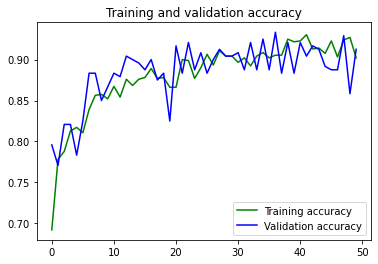

<Figure size 432x288 with 0 Axes>

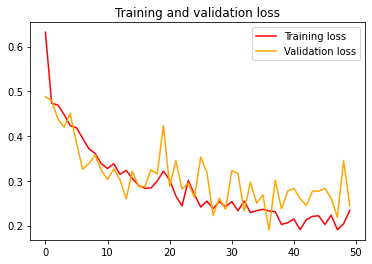

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

In [19]:
newModel = modelCreation()

# Loads the weights

newModel.load_weights(checkpoint_path)

# Evaluate the saved model

loss, acc = newModel.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 54, 54, 100)       36400     
_________________________________________________________________
average_pooling2d_9 (Average (None, 26, 26, 100)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 100)       250100    
_________________________________________________________________
average_pooling2d_10 (Averag (None, 10, 10, 100)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 6, 6, 50)          125050    
_________________________________________________________________
average_pooling2d_11 (Averag (None, 2, 2, 50)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 200)              

## CNN training - Second set

In [20]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def modelCreation():
    model = Sequential([
              Conv2D(100, (11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 3)),
              MaxPooling2D(pool_size = (3,3), strides=(2,2)),
              Conv2D(100, (5,5), activation='relu'),
              MaxPooling2D(pool_size = (3,3), strides=(2,2)),
              Conv2D(50, (5,5), activation='relu'),
              MaxPooling2D(pool_size = (3,3), strides=(2,2)),
              Flatten(),
              Dropout(0.2),
              Dense(2048, activation='relu'),
              Dropout(0.2),
              Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['acc'])
    model.summary()
    return(model)

model = modelCreation()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 54, 54, 100)       36400     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 100)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 22, 100)       250100    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 100)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 6, 6, 50)          125050    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 50)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 200)              

In [21]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Creating a callback that saves the model weights after every epoch

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [22]:
# Train the model with the new callback so that we don't have to train the model repeatedly

history = model.fit(train_generator,
                    steps_per_epoch = 15,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps = 15,
                    callbacks=[cp_callback])

Epoch 1/50
15/15 [==============================] - 38s 3s/step - loss: 0.6647 - acc: 0.6004 - val_loss: 0.4690 - val_acc: 0.8167

Epoch 00001: saving model to training_2\cp.ckpt
Epoch 2/50
15/15 [==============================] - 38s 3s/step - loss: 0.4472 - acc: 0.8216 - val_loss: 0.4103 - val_acc: 0.8417

Epoch 00002: saving model to training_2\cp.ckpt
Epoch 3/50
15/15 [==============================] - 38s 3s/step - loss: 0.4248 - acc: 0.8162 - val_loss: 0.4396 - val_acc: 0.8417

Epoch 00003: saving model to training_2\cp.ckpt
Epoch 4/50
15/15 [==============================] - 38s 3s/step - loss: 0.3787 - acc: 0.8472 - val_loss: 0.3725 - val_acc: 0.8375

Epoch 00004: saving model to training_2\cp.ckpt
Epoch 5/50
15/15 [==============================] - 37s 2s/step - loss: 0.3223 - acc: 0.8673 - val_loss: 0.2925 - val_acc: 0.9000

Epoch 00005: saving model to training_2\cp.ckpt
Epoch 6/50
15/15 [==============================] - 37s 2s/step - loss: 0.3167 - acc: 0.8610 - val_loss: 


Epoch 00046: saving model to training_2\cp.ckpt
Epoch 47/50
15/15 [==============================] - 45s 3s/step - loss: 0.1476 - acc: 0.9400 - val_loss: 0.2541 - val_acc: 0.9125

Epoch 00047: saving model to training_2\cp.ckpt
Epoch 48/50
15/15 [==============================] - 41s 3s/step - loss: 0.1707 - acc: 0.9319 - val_loss: 0.2461 - val_acc: 0.9125

Epoch 00048: saving model to training_2\cp.ckpt
Epoch 49/50
15/15 [==============================] - 44s 3s/step - loss: 0.1787 - acc: 0.9155 - val_loss: 0.2641 - val_acc: 0.9083

Epoch 00049: saving model to training_2\cp.ckpt
Epoch 50/50
15/15 [==============================] - 45s 3s/step - loss: 0.1556 - acc: 0.9408 - val_loss: 0.2262 - val_acc: 0.9208

Epoch 00050: saving model to training_2\cp.ckpt


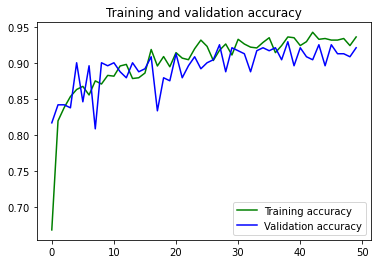

<Figure size 432x288 with 0 Axes>

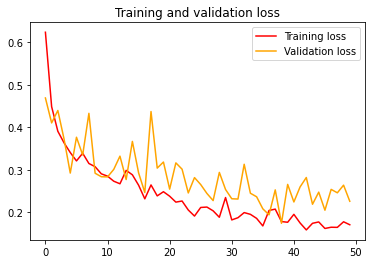

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
newModel = modelCreation()

# Loads the weights

newModel.load_weights(checkpoint_path)

# Evaluate the saved model

loss, acc = newModel.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 54, 54, 100)       36400     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 100)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 22, 100)       250100    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 100)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 6, 50)          125050    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 50)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 200)              

## CNN Training - Third Set

In [25]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def modelCreation():
    model = Sequential([
              Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 3)),
              MaxPooling2D(pool_size = (3,3), strides=(2,2)),
              Conv2D(256, (5,5), activation='relu'),
              MaxPooling2D(pool_size = (3,3), strides=(2,2)),
              Conv2D(384, (5,5), activation='relu'),
              MaxPooling2D(pool_size = (3,3), strides=(2,2)),
              Flatten(), #Flattens the input from the prev layer
              Dropout(0.2),
              Dense(2048, activation='relu'),
              Dropout(0.25),
              Dense(1024, activation='relu'),
              Dropout(0.2),
              Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['acc'])
    model.summary()
    return(model)

model = modelCreation()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 6, 6, 384)         2457984   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 384)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1536)             

In [26]:
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [27]:
# Train the model with the new callback
history = model.fit(train_generator,
                    steps_per_epoch = 15,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps = 15,
                    callbacks=[cp_callback])  # Pass callback to training

Epoch 1/50
15/15 [==============================] - 52s 3s/step - loss: 0.6086 - acc: 0.6568 - val_loss: 0.4718 - val_acc: 0.7917

Epoch 00001: saving model to training_3\cp.ckpt
Epoch 2/50
15/15 [==============================] - 48s 3s/step - loss: 0.5181 - acc: 0.8049 - val_loss: 0.4389 - val_acc: 0.7833

Epoch 00002: saving model to training_3\cp.ckpt
Epoch 3/50
15/15 [==============================] - 47s 3s/step - loss: 0.4060 - acc: 0.8309 - val_loss: 0.3769 - val_acc: 0.8208

Epoch 00003: saving model to training_3\cp.ckpt
Epoch 4/50
15/15 [==============================] - 47s 3s/step - loss: 0.3643 - acc: 0.8285 - val_loss: 0.3280 - val_acc: 0.8792

Epoch 00004: saving model to training_3\cp.ckpt
Epoch 5/50
15/15 [==============================] - 48s 3s/step - loss: 0.3477 - acc: 0.8416 - val_loss: 0.3232 - val_acc: 0.8708

Epoch 00005: saving model to training_3\cp.ckpt
Epoch 6/50
15/15 [==============================] - 47s 3s/step - loss: 0.3285 - acc: 0.8743 - val_loss: 

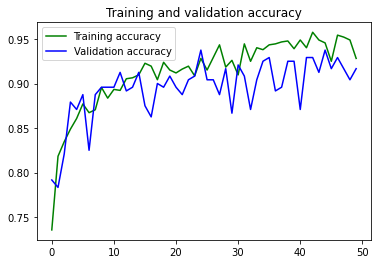

<Figure size 432x288 with 0 Axes>

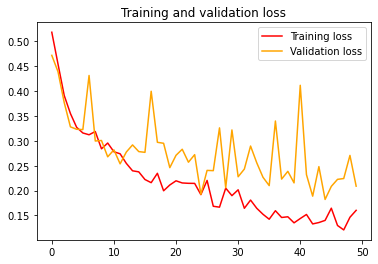

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

In [29]:
newModel = modelCreation()

# Loads the weights

newModel.load_weights(checkpoint_path)

# Evaluate the saved model

loss, acc = newModel.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 6, 6, 384)         2457984   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 2, 384)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1536)             

In [30]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [31]:
newModel = modelCreation()

# Loads the weights

newModel.load_weights(checkpoint_path)

# Evaluate the saved model

loss, acc = newModel.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 6, 6, 384)         2457984   
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 2, 2, 384)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1536)            

## Inception v3 Model

First set

In [37]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(2, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [38]:
checkpoint_path = "training_incep1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [39]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.2099 and logs.get('loss')<=0.1500):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = myCallback()

history2 = model1.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks, cp_callbacks]
)

Epoch 1/20
14/14 [==============================] - 60s 4s/step - loss: 1.7910 - acc: 0.5030 - val_loss: 0.6931 - val_acc: 0.5982

Epoch 00001: saving model to training_incep1\cp.ckpt
Epoch 2/20
14/14 [==============================] - 56s 4s/step - loss: 0.3990 - acc: 0.8048 - val_loss: 0.2490 - val_acc: 0.9286

Epoch 00002: saving model to training_incep1\cp.ckpt
Epoch 3/20
14/14 [==============================] - 54s 4s/step - loss: 0.2466 - acc: 0.8976 - val_loss: 0.2611 - val_acc: 0.9241

Epoch 00003: saving model to training_incep1\cp.ckpt
Epoch 4/20
14/14 [==============================] - 53s 4s/step - loss: 0.1741 - acc: 0.9293 - val_loss: 0.2029 - val_acc: 0.9375

Epoch 00004: saving model to training_incep1\cp.ckpt
Epoch 5/20
14/14 [==============================] - 53s 4s/step - loss: 0.2315 - acc: 0.9051 - val_loss: 0.4071 - val_acc: 0.8527

Epoch 00005: saving model to training_incep1\cp.ckpt
Epoch 6/20
14/14 [==============================] - 53s 4s/step - loss: 0.1877 -

In [41]:
loss, acc = model1.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

21/21 - 13s - loss: 0.0737 - acc: 0.9721
Model accuracy for the testing set: 97.21%


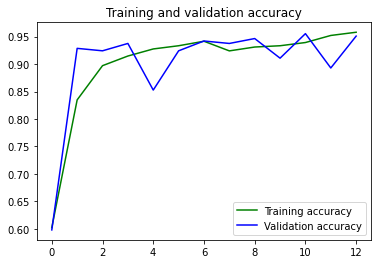

<Figure size 432x288 with 0 Axes>

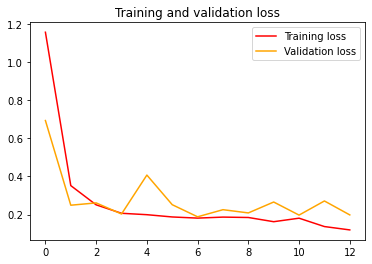

<Figure size 432x288 with 0 Axes>

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

Second set

In [43]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [44]:
checkpoint_path = "training_incep2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [45]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.2099 and logs.get('loss')<=0.1500):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = myCallback()

history1 = model1.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks, cp_callbacks]
)

Epoch 1/20
14/14 [==============================] - 86s 6s/step - loss: 9.8432 - acc: 0.6575 - val_loss: 0.2183 - val_acc: 0.9330

Epoch 00001: saving model to training_incep2\cp.ckpt
Epoch 2/20
14/14 [==============================] - 82s 6s/step - loss: 0.2370 - acc: 0.9027 - val_loss: 0.6391 - val_acc: 0.7902

Epoch 00002: saving model to training_incep2\cp.ckpt
Epoch 3/20
14/14 [==============================] - 81s 6s/step - loss: 0.4128 - acc: 0.8287 - val_loss: 0.2624 - val_acc: 0.9241

Epoch 00003: saving model to training_incep2\cp.ckpt
Epoch 4/20
14/14 [==============================] - 65s 5s/step - loss: 0.4181 - acc: 0.8490 - val_loss: 0.2463 - val_acc: 0.9375

Epoch 00004: saving model to training_incep2\cp.ckpt
Epoch 5/20
14/14 [==============================] - 60s 4s/step - loss: 0.3118 - acc: 0.8649 - val_loss: 0.2573 - val_acc: 0.9330

Epoch 00005: saving model to training_incep2\cp.ckpt
Epoch 6/20
14/14 [==============================] - 60s 4s/step - loss: 0.2375 -

In [46]:
loss, acc = model1.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

21/21 - 13s - loss: 0.0771 - acc: 0.9659
Model accuracy for the testing set: 96.59%


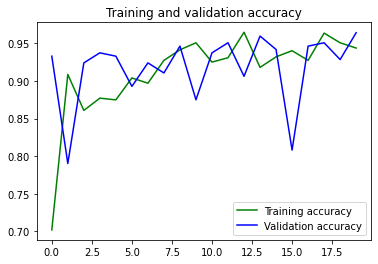

<Figure size 432x288 with 0 Axes>

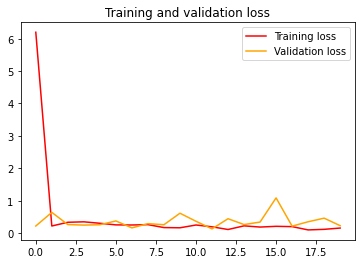

<Figure size 432x288 with 0 Axes>

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

Third Set

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [11]:
import os
checkpoint_path = "training_incep3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [12]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.2099 and logs.get('loss')<=0.1500):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 14,
    callbacks=[callbacks, cp_callbacks]
)

Epoch 1/20
14/14 [==============================] - 61s 4s/step - loss: 14.0327 - acc: 0.5643 - val_loss: 0.6771 - val_acc: 0.5804

Epoch 00001: saving model to training_incep3\cp.ckpt
Epoch 2/20
14/14 [==============================] - 59s 4s/step - loss: 0.4555 - acc: 0.8251 - val_loss: 0.2925 - val_acc: 0.9062

Epoch 00002: saving model to training_incep3\cp.ckpt
Epoch 3/20
14/14 [==============================] - 61s 4s/step - loss: 0.3401 - acc: 0.8406 - val_loss: 0.4528 - val_acc: 0.8304

Epoch 00003: saving model to training_incep3\cp.ckpt
Epoch 4/20
14/14 [==============================] - 64s 5s/step - loss: 0.3610 - acc: 0.8527 - val_loss: 0.3103 - val_acc: 0.9241

Epoch 00004: saving model to training_incep3\cp.ckpt
Epoch 5/20
14/14 [==============================] - 65s 5s/step - loss: 0.3222 - acc: 0.8707 - val_loss: 0.2850 - val_acc: 0.8884

Epoch 00005: saving model to training_incep3\cp.ckpt
Epoch 6/20
14/14 [==============================] - 66s 5s/step - loss: 0.1948 

In [14]:
loss, acc = model.evaluate(test_generator, verbose=2)
print("Model accuracy for the testing set: {:5.2f}%".format(100 * acc))

21/21 - 15s - loss: 0.0844 - acc: 0.9752
Model accuracy for the testing set: 97.52%


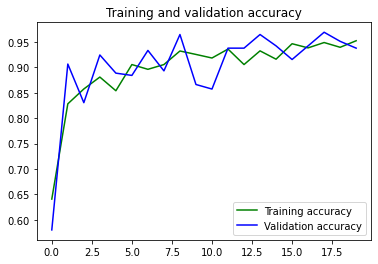

<Figure size 432x288 with 0 Axes>

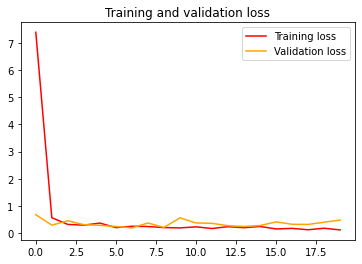

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.figure()
plt.show()

# Results

The models have given us very promising results, this will help in better fire detection than the primitive smoke detectors that we have now, the weights that we have saved of these models will be used to create a model in another file which will detect fire in a video from a webcam.

This will be revolutionary in the detection of fire and in the prevention of several thousand rupees of damages and possibly deaths.

In [19]:
import pandas as pd 

print("The results of each of the models is as follows \n")

obj = (pd.DataFrame([["CNN 1", 93.4, 90, 91.02],
                     ["CNN 2", 89.96, 90.83, 90.40],
                     ["CNN 3", 94.53, 91.67, 93.50],
                     ["InceptionV3 1", 95.12, 94.64, 96.90],
                     ["InceptionV3 2", 95.80, 95.09, 97.21],
                     ["InceptionV3 3", 96.07, 93.75, 97.52]], columns = ["Model", "Training Accuracy", "Validation Accuracy", "Testing Accuracy"]))

print(obj)

The results of each of the models is as follows 

           Model  Training Accuracy  Validation Accuracy  Testing Accuracy
0          CNN 1              93.40                90.00             91.02
1          CNN 2              89.96                90.83             90.40
2          CNN 3              94.53                91.67             93.50
3  InceptionV3 1              95.12                94.64             96.90
4  InceptionV3 2              95.80                95.09             97.21
5  InceptionV3 3              96.07                93.75             97.52
